In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import itertools as it
from sklearn.preprocessing import StandardScaler, normalize
import warnings

from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.impute import KNNImputer

from sklearn.linear_model import LinearRegression,LogisticRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingRegressor, StackingRegressor, GradientBoostingRegressor, BaggingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
from pyearth import Earth

In [41]:
train = pd.read_csv('data/train.csv')
train.shape

(5380, 767)

In [42]:
test = pd.read_csv('data/test.csv')
test.shape

(4403, 766)

## Missing Vals

In [43]:
num_missing = train.isna().sum().sum()
print(num_missing)

num_cols_missing = (train.isna().any()).sum()
print(num_cols_missing)

num_rows_missing = (train.isna().any(axis=1)).sum()
print(num_rows_missing)

29911
473
2523


In [44]:
y_train = train['y']
X_train = train.drop(['y', 'id'], axis = 1)

In [45]:
col_id = test['id']
X_test = test.drop(['id'], axis = 1)

In [46]:
col_names = X_train.columns.tolist()

#Scaling
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scl = pd.DataFrame(scaler.transform(X_train), columns = col_names)
X_test_scl = pd.DataFrame(scaler.transform(X_test), columns = col_names)

In [47]:
#KNN Imputation
imputer = KNNImputer(n_neighbors = 5)
X_train = pd.DataFrame(imputer.fit_transform(X_train_scl), columns = X_train.columns)
X_test = pd.DataFrame(imputer.fit_transform(X_test_scl), columns = X_test.columns)

## Feature Selection/Engineering

In [49]:
corr = abs(X_train.corrwith(y_train))
corr[corr.isnull()==True]

x063   NaN
x137   NaN
x255   NaN
x385   NaN
x405   NaN
x453   NaN
x465   NaN
x518   NaN
x594   NaN
x643   NaN
x703   NaN
dtype: float64

In [50]:
#Drop column of 0/1
X_train = X_train.drop(['x063', 'x137', 'x255', 'x385', 'x405', 'x453', 'x465', 'x518', 'x594', 'x643', 'x703'], axis = 1)
X_test = X_test.drop(['x063', 'x137', 'x255', 'x385', 'x405', 'x453', 'x465', 'x518', 'x594', 'x643', 'x703'], axis = 1)
print(X_train.shape)

(5380, 754)


In [38]:
#Drop col with low var
var = X_train.var()
low_var_col = var[var < 0.1].index.tolist()
low_var_col
#X_train.drop(low_var_col, axis=1, inplace=True)
#X_test.drop(low_var_col, axis=1, inplace=True)
#print(X_train.shape)

[]

In [33]:
#Drop correlated cols
corr_matrix = X_train.corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
corr_columns = [column for column in upper_tri.columns if any(upper_tri[column] > 0.90)]

X_train = X_train.drop(corr_columns, axis=1)
X_test = X_test.drop(corr_columns, axis=1)
print(X_train.shape)

(5380, 269)


<ipython-input-33-1fbc6b37a092>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


In [34]:
#Scaling
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [35]:
#PCA
pca = PCA(0.90)
pca.fit(X_train)

X_train = pca.transform(X_train)
X_train.shape

(5380, 104)

In [36]:
X_test = pca.transform(X_test)
X_test.shape

(4403, 104)

## AdaBoost

>3 11.823 (0.481)
>4 11.760 (0.574)
>5 11.712 (0.470)
>6 11.884 (0.442)
>7 11.827 (0.462)
>8 11.910 (0.531)
>9 11.935 (0.422)
>10 12.068 (0.495)
>11 12.033 (0.358)
>12 12.150 (0.377)
>13 12.266 (0.365)
>14 12.328 (0.373)


Text(0.5, 0, 'Number of trees')

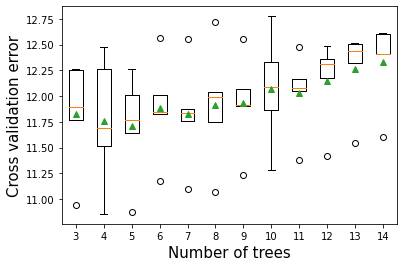

In [119]:
def get_models():
    models = dict()
    for n in range(3, 15):
        models[str(n)] = AdaBoostRegressor(n_estimators=n,random_state=1)
    return models

def evaluate_model(model, X_train, y_train):
    cv = KFold(n_splits=5, shuffle=True, random_state=1)
    scores = np.sqrt(-cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

models = get_models()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train, y_train)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
    
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Number of trees',fontsize=15)

>1 12.551 (0.748)
>2 13.362 (1.046)
>3 13.711 (0.764)
>4 13.290 (0.804)
>5 12.252 (0.964)
>6 11.364 (1.137)
>7 10.738 (1.338)
>8 10.656 (1.395)
>9 10.595 (1.463)
>10 10.557 (1.491)


Text(0.5, 0, 'Depth of each tree')

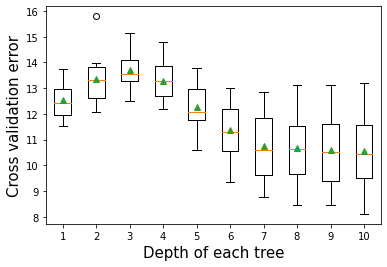

In [120]:
def get_models():
    models = dict()
    for i in range(1,11):
        base = DecisionTreeRegressor(max_depth=i)
        models[str(i)] = AdaBoostRegressor(base_estimator=base,n_estimators=50)
    return models

def evaluate_model(model, X, y):
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

models = get_models()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train, y_train)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
    
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Depth of each tree',fontsize=15)

In [121]:
model = AdaBoostRegressor(random_state=1)
grid = dict()
grid['n_estimators'] = [4, 5]
grid['base_estimator'] = [DecisionTreeRegressor(max_depth=5), DecisionTreeRegressor(max_depth=6)]

cv = KFold(n_splits=5, shuffle=True, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='neg_mean_squared_error')
grid_result = grid_search.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

Best: -123.021009 using {'base_estimator': DecisionTreeRegressor(max_depth=6), 'n_estimators': 5}


In [37]:
model_ADA = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=6), n_estimators=5,
                              random_state=1).fit(X_train, y_train)

## XGBoost

>2 11.965 (0.705)
>3 11.308 (0.646)
>4 10.979 (0.596)
>5 10.817 (0.576)
>6 10.701 (0.543)


Text(0.5, 0, 'Number of trees')

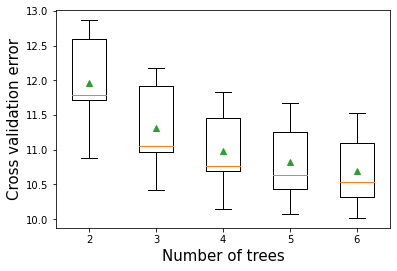

In [128]:
def get_models():
    models = dict()
    for n in range(2, 7):
        models[str(n)] = xgb.XGBRegressor(n_estimators=n,random_state=1)
    return models

def evaluate_model(model, X, y):
    cv = KFold(n_splits=5, shuffle=True, random_state=1)
    scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

models = get_models()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train, y_train)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))

plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Number of trees',fontsize=15)

>1 10.337 (1.384)
>2 10.284 (1.287)
>3 10.405 (1.177)
>4 10.549 (1.183)
>5 10.753 (1.007)
>6 10.817 (1.021)


Text(0.5, 0, 'Depth of each tree')

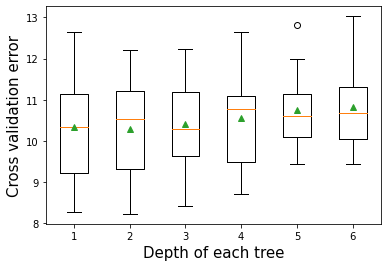

In [127]:
def get_models():
    models = dict()
    for i in range(1, 7):
        models[str(i)] = xgb.XGBRegressor(random_state=1,max_depth=i)
    return models

def evaluate_model(model, X, y):
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

models = get_models()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train, y_train)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
    
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Depth of each tree',fontsize=15)

>0.0100 11.2 (1.5)
>0.0200 10.5 (1.4)
>0.0500 10.3 (1.2)
>0.1000 10.3 (1.1)


Text(0.5, 0, 'Learning rate')

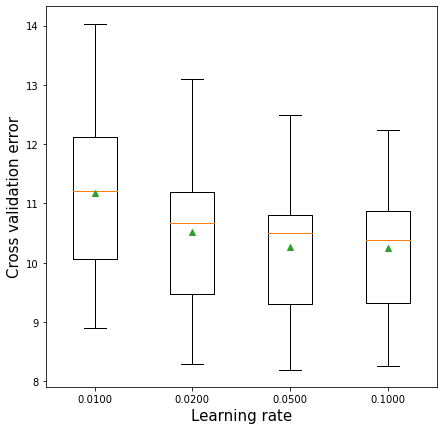

In [129]:
def get_models():
    models = dict()
    for i in [0.010, 0.020, 0.050, 0.1]:
        key = '%.4f' % i
        models[key] = xgb.XGBRegressor(learning_rate=i,random_state=1)
    return models

def evaluate_model(model, X, y):
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

models = get_models()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train, y_train)
    results.append(scores)
    names.append(name)
    print('>%s %.1f (%.1f)' % (name, np.mean(scores), np.std(scores)))
    
plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Learning rate',fontsize=15)

>0.0100 11.1 (1.1)
>0.0500 11.1 (1.3)
>0.1000 11.1 (1.3)
>0.2500 10.9 (1.1)
>0.5000 11.0 (1.0)
>1.0000 10.8 (1.0)


Text(0.5, 0, 'reg_lambda')

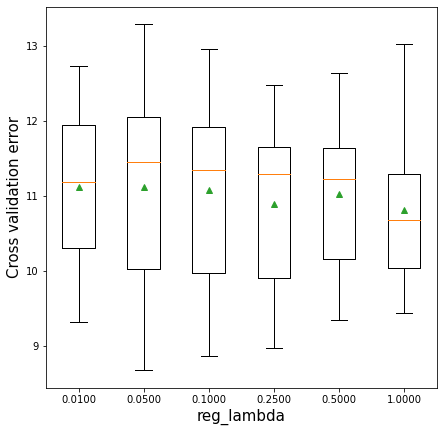

In [130]:
def get_models():
    models = dict()
    for i in [0.01, 0.05, 0.1, 0.25, 0.5, 1]:
        key = '%.4f' % i
        models[key] = xgb.XGBRegressor(reg_lambda=i,random_state=1)
    return models

def evaluate_model(model, X, y):
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

models = get_models()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train, y_train)
    results.append(scores)
    names.append(name)
    print('>%s %.1f (%.1f)' % (name, np.mean(scores), np.std(scores)))

plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('reg_lambda',fontsize=15)

In [131]:
param_grid = {'n_estimators':[3, 4],
              'max_depth': [1, 2, 3, 4],
              'learning_rate': [0.100, 0.125, 0.150],
              'reg_lambda':[0.15, 0.20, 0.25]}

cv = KFold(n_splits=5,shuffle=True,random_state=1)
optimal_params = GridSearchCV(estimator=xgb.XGBRegressor(random_state=1),                                                       
                             param_grid = param_grid,                             
                             verbose = 1,
                             n_jobs=-1,
                             cv = cv)
optimal_params.fit(X_train , y_train)
print("Optimal parameter values =", optimal_params.best_params_)
print("Optimal cross validation R-squared = ",optimal_params.best_score_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Optimal parameter values = {'learning_rate': 0.15, 'max_depth': 4, 'n_estimators': 4, 'reg_lambda': 0.15}
Optimal cross validation R-squared =  0.019748166955814116


In [38]:
model_XG = xgb.XGBRegressor(random_state=1, max_depth=4, n_estimators=4, learning_rate = 0.15, reg_lambda=0.2).fit(X_train, y_train)

## Ensemble

In [39]:
model_ensemble= StackingRegressor(estimators = [('ADA', model_ADA),
                                               ('XG', model_XG)],
                      final_estimator = LassoCV(),
                      cv = KFold(n_splits = 5, shuffle = True, random_state=1))
model_ensemble.fit(X_train, y_train)

StackingRegressor(cv=KFold(n_splits=5, random_state=1, shuffle=True),
                  estimators=[('ADA',
                               AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=6),
                                                 n_estimators=5,
                                                 random_state=1)),
                              ('XG',
                               XGBRegressor(base_score=0.5, booster='gbtree',
                                            callbacks=None, colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1,
                                            early_stopping_rounds=None,
                                            enable_catego...
                                            gpu_id=-1, grow_policy='depthwise',
                                            importance_type=None,
                                            interaction_c

In [40]:
pred17 = model_ensemble.predict(X_test)

pred_v17 = pd.DataFrame(index=range(X_test.shape[0]), columns=range(2))
pred_v17.columns = ['id', 'y']
pred_v17['id'] = col_id
pred_v17['y'] = pred17
pred_v17

,id,y
0,5380,7.335179
1,5381,9.452303
2,5382,6.623761
3,5383,7.842693
4,5384,8.014691
...,...,...
4398,9778,4.968972
4399,9779,8.100296
4400,9780,11.068754
4401,9781,10.645289


In [41]:
pred_v17.to_csv('pred_v17.csv', index=True)